<a href="https://colab.research.google.com/github/Alenushka2013/Coursera/blob/master/125587_20_2_hw_ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. Композиции алгоритмов
В этом домашнем задании вам предстоит обучить два вида композиций алгоритмов: бэггинг и бустинг.

## Постановка задачи
Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

## Метрика качества
В качестве целевой метрики мы будем использовать ROC-AUC. Об этой метрике мы говорили в модуле о метриках. Как вы помните, для измерения ROC-AUC требуются вероятности принадлежности к классам. Для решающих деревьев вероятность принадлежности к классу вычисляется как доля объектов из обучающей выборки в соответствующем листе. Для алгоритма, который принимает решение взвешенным голосованием, вероятность вычисляется как среднее взвешенное значение вероятностей по всем алгоритмам в композиции.

## Ход работы
* Первым делом вы произведете загрузку и обработку данных. В частности, вам необходимо будет закодировать категориальные признаки с помощью One-hot encoding.
* Сначала мы построим для нашей задачи обычный случайный лес и измерим его качество. Мы подберем оптимальный гиперпараметр "глубина дерева" для случайного леса.
* Далее мы обучим алгоритм градиентного бустинга с помощью библиотеки Catboost. Catboost --- это библиотека для градиентного бустинга, которая автоматически обрабатывает категориальные признаки. Поэтому для этого пункта вам нужно будет использовать не One-hot признаки, а изначальные категориальные признаки.

## Оценивание
В этом домашнем задании данные разделены на две части:
* [`data_train.csv`](https://drive.google.com/file/d/1qKakViWhNT1yTiM66V9hxADAVCYTL0PO/view?usp=share_link). Для этих данных вам известно значение целевой переменной. Эти данные вы будете использовать для обучения.
* [`data_scoring.csv`](https://drive.google.com/file/d/1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ/view?usp=share_link). На этих данных вы должны будете применить готовую модель, а затем сдать результаты в Stepik. Вам необходимо будет сдать результат работы двух моделей: случайного леса и градиентного бустинга.



## Часть 1. Загрузка и обработка данных
Загрузка данных будет состоять из следующих шагов:
* Загрузка из файла;
* Работа с пропущенными значениями;
* Выделение целевой переменной;
* Разбиение данных на вещественные и категориальные;
* One-hot кодирование категориальных данных;
* Разбиение данных на train и test.

Затем все эти шаги (кроме последнего) необходимо будет применить к `data_scoring`.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
!gdown 1qKakViWhNT1yTiM66V9hxADAVCYTL0PO #эта команда скачивает файл data_train.csv и помещает его в корневую директорию Colab. Очень удобно!

Downloading...
From: https://drive.google.com/uc?id=1qKakViWhNT1yTiM66V9hxADAVCYTL0PO
To: /content/data_train.csv
100% 1.40M/1.40M [00:00<00:00, 72.8MB/s]


In [55]:
data = pd.read_csv('data_train.csv')

In [4]:
data.shape

(14734, 14)

In [5]:
data[:10]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


### Задание
Проведите с данными необходимые операции:

* Замените все знаки "?" на `np.nan`.
* Найдите все столбцы со значениями NaN. Напечатайте их названия.
* Выделите вектор ответов. Закодируйте правильные ответы 0 и 1:
    * '<=50K' -> 0;
    * '>50K' -> 1.
* Сохраните их в отдельную переменную `y` типа `np.array`.
* Удалите из data правильные ответы.

In [56]:
data.replace('?', np.nan, inplace=True)
# print(*data.columns[data.isna().sum() > 0])
# y = data['>50K,<=50K'].apply(lambda x: 0 if x == '<=50K' else 1).to_numpy()
# data.drop('>50K,<=50K', axis = 1, inplace = True)

**Вопрос**. В каких колонках присутствуют пропущенные значения?

In [7]:
# Найдите колонки с пропущенными значениями
print(*data.columns[data.isna().sum() > 0])

workclass occupation


In [57]:
# ВАШ КОД
y = data['>50K,<=50K'].apply(lambda x: 0 if x == '<=50K' else 1).to_numpy()
y = y.astype(np.int32, copy=False)
y.shape

(14734,)

Удалим ответы из data.

In [58]:
data = data.drop('>50K,<=50K',axis =  1)

In [10]:
data.shape

(14734, 13)

**Вопрос**. Какие из признаков являются вещественными?

Выделите вещественные и категориальные признаки.

In [59]:
real_columns = data.select_dtypes(include=np.number).columns.tolist()

real_data = data[real_columns]
real_data[:10]

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
5,18,446771,10,0,0,25
6,31,108464,12,0,0,40
7,18,423460,7,0,0,36
8,25,110138,9,0,0,40
9,53,167410,13,0,0,40


In [60]:
cat_columns = data.select_dtypes('object').columns.tolist()
cat_data = data[cat_columns]
cat_data[:10]

,workclass,education,marital-status,occupation,relationship,race,sex
0,Local-gov,HS-grad,Never-married,Farming-fishing,Not-in-family,Black,Male
1,Private,Some-college,Divorced,Sales,Not-in-family,White,Male
2,Local-gov,Bachelors,Married-civ-spouse,Prof-specialty,Own-child,White,Male
3,Private,Some-college,Never-married,Sales,Own-child,White,Female
4,Private,Bachelors,Married-civ-spouse,Tech-support,Husband,White,Male
5,Private,Some-college,Never-married,Adm-clerical,Own-child,White,Male
6,Federal-gov,Assoc-acdm,Married-civ-spouse,Tech-support,Husband,White,Male
7,NaN,11th,Never-married,NaN,Own-child,White,Male
8,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Male
9,Federal-gov,Bachelors,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male


### Задание
Выделите One-hot признаки из данных с помощю объекта `OneHotEncoder` из модуля `sklearn.preprocessing`.

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [14]:
? OneHotEncoder

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
one_hot_data = ohe.fit_transform(cat_data)
one_hot_data = pd.DataFrame(one_hot_data, index=cat_data.index, columns=ohe.get_feature_names_out())
one_hot_data[:10]

Наконец, разобьем данные на train и test в соотношении 70:30.

In [61]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_real_data, test_real_data, \
train_cat_data, test_cat_data, train_one_hot_data, test_one_hot_data, \
y_train, y_test = train_test_split(data, real_data,
                                   cat_data, one_hot_data,
                                   y, train_size=0.7)

In [62]:
train_data.shape

(10313, 13)

### Задание
Проделайте все то же самые операции для scoring_data.
* Загрузите данные из файла data_scoring.csv;
* Замените "?" на `np.nan`;
* Выделите числовые и категориальные данные;
* Закодируйте категориальные данные с помощью уже созданного `ohe`. Новый объект класса `OneHotEncoding` создавать не нужно. Используйте метод `ohe.transform`.

In [18]:
!gdown 1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ

Downloading...
From: https://drive.google.com/uc?id=1tguHTZm9-sUwTRzqAEuqLRUzKHqkvVmQ
To: /content/data_scoring.csv
100% 139k/139k [00:00<00:00, 72.0MB/s]


In [19]:
scoring_data = pd.read_csv('/content/data_scoring.csv')
scoring_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week
0,17,?,256173,10th,6,Never-married,?,Own-child,White,Female,0,0,15
1,31,Private,265706,Bachelors,13,Never-married,Sales,Not-in-family,White,Male,0,0,40
2,61,Self-emp-not-inc,244087,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,52
3,60,Local-gov,232618,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40
4,56,Private,34626,Some-college,10,Divorced,Exec-managerial,Not-in-family,White,Female,0,1980,40


In [20]:
scoring_data.replace('?', np.nan, inplace=True)

In [ ]:

# real_columns = data.select_dtypes(include=np.number).columns.tolist()
# real_data = data[real_columns]
real_columns = scoring_data.select_dtypes(include=np.number).columns.tolist()
scoring_real_data = scoring_data[real_columns]

scoring_cat_data = scoring_data[scoring_data.select_dtypes('object').columns.tolist()]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scoring_one_hot_data = ohe.fit_transform(scoring_cat_data)
scoring_one_hot_data = pd.DataFrame(scoring_one_hot_data, index=scoring_cat_data.index, columns=ohe.get_feature_names_out())
scoring_one_hot_data[:10]


## Часть 2. Обучение случайного леса
Мы будем использовать модель `RandomForestClassifier` из `sklearn.ensemble`. Вам предстоит подобрать для случайного леса оптимальный параметр глубины. Количество деревьев в этом задании мы будем использовать постоянным и равным 100.

Выбор параметра мы будем производить с помощью кросс-валидации на 5 фолдов, используя метод `cross_val_score` из `sklearn.model_selection`. Затем мы обучим окончательную модель на всем `train_data`, а на `test_data` будем считать итоговое качество.

Отметим, что для моделей `sklearn` мы не можем по умолчанию использовать категориальные признаки. Поэтому мы будем использовать `train/test_one_hot_data`.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

Создадим полную матрицу объекты-признаки. Используем числовые и one-hot данные.

In [23]:
train_data_for_forest = pd.concat([train_real_data, train_one_hot_data], axis='columns')
test_data_for_forest = pd.concat([test_real_data, test_one_hot_data], axis='columns')

### Задание
Выберите оптимальный параметр max_depth от 3 до 19 включительно для модели случаного леса. Используйте кросс-валидацию. Для каждой глубины посчитайте среднее по фолдам значение метрики ROC-AUC и запишите получившиеся данные в массив `rf_metrics`. Используйте 5 фолдов для кросс-валидации.

**Совет**. Для ускорения работы функции `cross_val_score` используйте параметр n_jobs=-1.

In [24]:
print(train_data_for_forest.shape)
print(y.shape)


(10313, 66)
(14734,)


In [25]:
depths = np.arange(3, 20)
rf_metrics = []
train_data_for_forest.columns = train_data_for_forest.columns.astype(str)

for depth in depths:
    rf = RandomForestClassifier(random_state=42, max_depth=depth, n_jobs=-1)

    # Оцінюємо модель за допомогою кросс-валидації та метрики ROC-AUC
    scores = cross_val_score(rf, train_data_for_forest, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    rf_metrics.append(np.mean(scores))

Построим график получившейся метрики в зависимости от параметра `depth`.

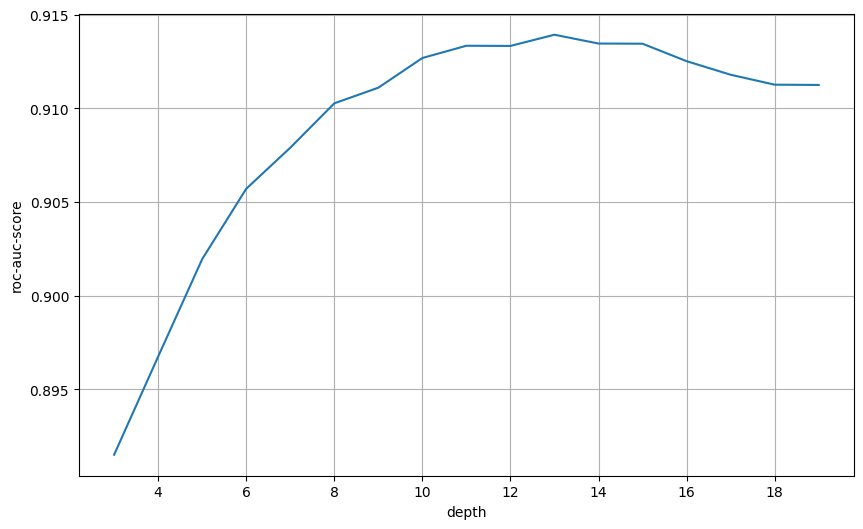

In [26]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics)
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()

### Задание
Выберите оптимальное значение глубины и обучите для этого значения единственную модель `RandomForestClassifier` на всех обучающих данных `train_data_for_forest`. Предскажите вероятность класса 1 на обучающих и тестовых данных. Сохраните их в переменные `train_y_pred_forest` и `test_y_pred_forest`. Используйте метод `predict_proba`.

In [27]:
best_depth = np.argmax(rf_metrics)+3
test_data_for_forest.columns = test_data_for_forest.columns.astype(str)

model = RandomForestClassifier(n_estimators=100, max_depth=best_depth)

#ВАШ КОД. Обучите модель
model.fit(train_data_for_forest, y_train)

train_y_pred_forest = model.predict_proba(train_data_for_forest)[:, 1]  #ВАШ КОД
test_y_pred_forest =  model.predict_proba(test_data_for_forest)[:, 1]  #ВАШ КОД

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

In [29]:
train_auc = roc_auc_score(y_train, train_y_pred_forest) #ВАШ КОД
test_auc = roc_auc_score(y_test, test_y_pred_forest) #ВАШ КОД

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [30]:
assert test_auc > 0.90

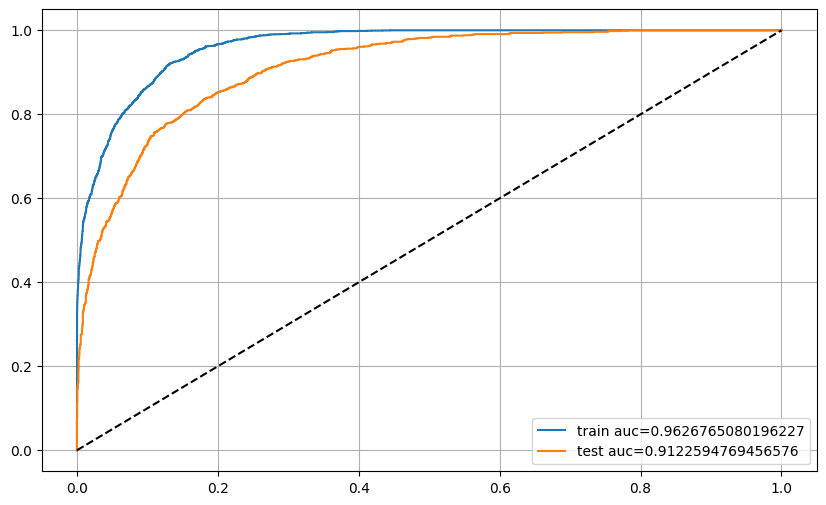

In [31]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_forest)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_forest)[:2],
         label=f'test auc={test_auc}')


plt.plot([0,1], [0,1], '--', color='black')
plt.legend()
plt.grid()

In [32]:
scoring_data_for_forest = pd.concat([scoring_real_data, scoring_one_hot_data], axis='columns') #ВАШ КОД
scoring_data_for_forest.columns = scoring_data_for_forest.columns.astype(str)

# Беремо всі колонки з train і додаємо недостаючі у scoring, заповнюючи їх нулями
for col in train_data_for_forest.columns:
    if col not in scoring_data_for_forest.columns:
        scoring_data_for_forest[col] = 0

# Упорядкуємо колонки у тому ж порядку, що й у train
scoring_data_for_forest = scoring_data_for_forest[train_data_for_forest.columns]

scoring_y_pred_forest = model.predict_proba(scoring_data_for_forest)[:, 1] #ВАШ КОД

In [33]:
print(scoring_y_pred_forest)

[8.12179153e-04 9.14579363e-02 2.91872819e-01 ... 3.39156123e-02
 2.30023287e-01 8.13830425e-01]


Сохраним scoring_y_pred_forest. Отправьте их на Stepik, полностью скопировав содержимое файла и вставив их вместо "<ВАШ КОД. Вставьте сюда list вероятностей, предсказанных случайным лесом на data_scoring.csv>" так, чтобы переменная answer содержала список вероятностей в нужном порядке.

In [34]:
with open('scoring_y_pred_forest.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_forest]))

Для посылки на kaggle обычно используют функцию `.to_csv`, как ниже, но нам этот код не понадобится:

In [35]:
pd.Series(scoring_y_pred_forest).to_csv('scoring_y_pred_forest.csv', header=None, index=None)

In [ ]:


# import pandas as pd

# import numpy as np

# from sklearn.preprocessing import OneHotEncoder

# from sklearn.ensemble import RandomForestClassifier



# # 1. Загрузка данных

# train_data = pd.read_csv('data_train.csv')

# scoring_data = pd.read_csv('data_scoring.csv')



# # Проверка первых строк для идентификации целевой переменной
# # display("Колонки в train_data:\n", train_data.columns.tolist())

# # display("Первые строки train_data:\n", train_data.head())



# # 2. Предобработка данных

# def preprocess(df):

#   df.replace("?", np.nan, inplace = True)

# # Заполнение пропусков для категориальных признаков

#   cat_cols = df.select_dtypes(include=['object']).columns

#   for col in cat_cols:

#     df[col] = df[col].fillna('Unknown')

#   return df



# train_data = preprocess(train_data)

# scoring_data = preprocess(scoring_data)

# # 3. Подготовка целевой переменной (используем правильное название)

# target_col = train_data.columns[-1]  # или другое название, которое показал вывод выше

# # y_train = train_data[target_col].replace({'<=50K': 0, '>50K': 1}).astype(int)

# y_train = train_data[target_col].apply(lambda x: 0 if x == '<=50K' else 1).to_numpy()

# train_data = train_data.drop(target_col, axis=1)

# # 4. Определение общих признаков

# numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()



# # 5. OneHot Encoding

# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# X_train_cat = encoder.fit_transform(train_data[categorical_cols])

# X_scoring_cat = encoder.transform(scoring_data[categorical_cols])



# # 6. Объединение признаков

# X_train = np.hstack([train_data[numeric_cols].values, X_train_cat])

# X_scoring = np.hstack([scoring_data[numeric_cols].values, X_scoring_cat])



# # 7. Обучение модели

# model = RandomForestClassifier(n_estimators=100, max_depth=14, random_state=42)

# model.fit(X_train, y_train)



# # 8. Предсказание для scoring данных

# scoring_probs = model.predict_proba(X_scoring)[:, 1]



# # 9. Проверка количества предсказаний

# assert len(scoring_probs) == len(scoring_data), f"Ожидалось {len(scoring_data)} предсказаний, получено {len(scoring_probs)}"



# # 10. Сохранение результатов

# with open('scoring_y_pred_forest.txt', 'w') as f:

# f.write(', '.join(map(str, scoring_probs)))

## Часть 3. Обучение градиентного бустинга
Мы будем использовать библиотеку Catboost. Catboost --- это библиотека для градиентного бустинга от компании Яндекс. Она, как следует из названия, отличается удобной работой с данными вообще и категориальными признаками с частности. Про Catboost можно прочитать в [официальной документации](https://catboost.ai/en/docs/concepts/python-usages-examples) и в статье на [Хабре](https://habr.com/ru/post/599827/).

<img src="https://avatars.mds.yandex.net/i?id=53d991f7cac35c76bf747793019c39fb-3751806-images-thumbs&n=13&exp=1" style="height:400px; width:800px">

Обратите внимание на следующие моменты:
* В Catboost можно сразу передавать категориальные признаки без предварительного кодирования.
* В Catboost для категориальных признаков необходимо заполнять пропущенные значения. Мы будем заполнять их значениями `'unknown'`.
* Для работы с данными в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_pool), который называется `Pool`. Прочитать о нем можно также в [примерах использования](https://catboost.ai/en/docs/concepts/python-usages-examples).
* Для кросс-валидации в Catboost [есть специальный класс](https://catboost.ai/en/docs/concepts/python-reference_cv) `cv`. Об использовании можно прочитать в статье на [Хабре](https://habr.com/ru/post/599827/).
* Собственно, основная модель для классификации в Catboost --- это `CatBoostClassifier`.

Для установки `catboost` вы можете выполнить следующую команду.

In [ ]:
!pip install catboost

Импортируем все необходимые классы.

In [38]:
from catboost import CatBoostClassifier, Pool, cv

### Задание
Заполните пропуски в данных `train_cat_data` и `test_cat_data` значением `'unknown'`. Используйте метод `fillna`.

In [63]:
train_cat_data = train_cat_data.fillna('unknown')
test_cat_data = test_cat_data.fillna('unknown')

### Задание
Создайте новые наборы данных для train и test, состоящие из `[train/test]_real_data` и `[train/test]_cat_data`. Используйте `pd.concat`. Затем создайте обучающий и тестовый `Pool` (за вас мы выделили номера категориальных признаков).

In [64]:
train_data_for_boosting = pd.concat([train_real_data,train_cat_data], axis='columns') #ВАШ КОД. Используйте pd.concat
test_data_for_boosting =  pd.concat([test_real_data,test_cat_data], axis='columns')#ВАШ КОД. Используйте pd.concat

cat_features = np.arange(train_cat_data.shape[1]) + train_real_data.shape[1]

train_dataset = Pool(data=train_data_for_boosting,
                     label=y_train,
                     cat_features=cat_features)

test_dataset =  Pool(data=test_data_for_boosting,
                     label=y_test,
                     cat_features=cat_features)

Для каждого значения depth от 3 до 16 включительно используйте функцию `cv` для подсчета результатов кросс-валидации. Затем посчитайте среднее по фолдам значение метрики ROC-AUC с последней итерации и запишите получившиеся данные в массив `boosting_metrics`.

Обратите внимание, что функция `cv` должна принимать следующие параметры:
* `pool` (используйте `train_dataset`)
* `params` (используйте параметры, указанные в коде)
* `fold_count` (положите равным 5).

Функция cv возвращает pd.DataFrame с метриками обучения. Вам понадобится колонка `'test-AUC-mean'` и последняя строчка. Обратите внимание, что обучение занимает значительное время! Сначала можете попробовать выполнить этот код для небольшого массива `depths`, чтобы было легче дебагать.

In [ ]:
depths = np.arange(3, 17)
boosting_metrics = []

for depth in depths:
    params = {"iterations": 100,
              "depth": depth,
              "loss_function": "Logloss",
              "custom_loss": "AUC",
              "verbose": False}

    scores = cv(train_dataset,
            params,
            fold_count=5,
            plot="True")
    #print (list(scores['test-AUC-mean'][-1:].values)[0])
    boosting_metrics.append(list(scores['test-AUC-mean'][-1:].values)[0])

Построим график получившейся метрики в зависимости от параметра `depth`. Сравним его с тем же графиком для метрик случайного леса.

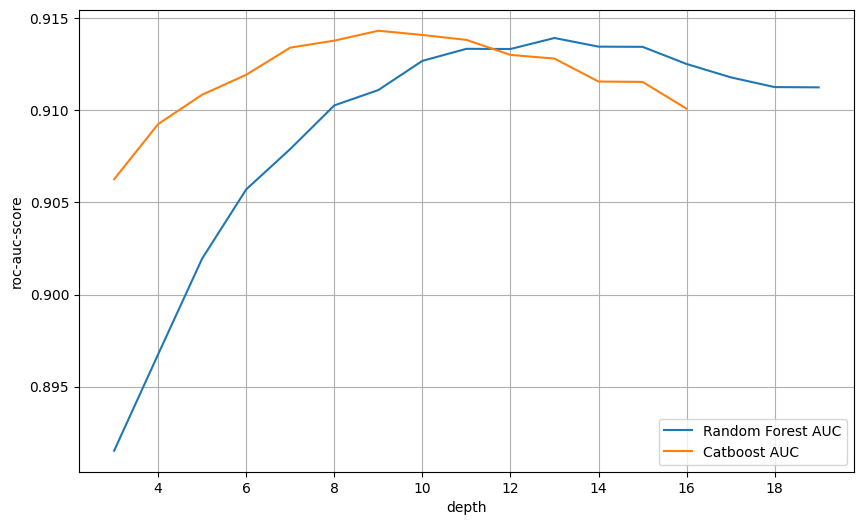

In [66]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(3, 20), rf_metrics, label='Random Forest AUC')
plt.plot(np.arange(3, 17), boosting_metrics, label='Catboost AUC')
plt.xlabel('depth')
plt.ylabel('roc-auc-score')
plt.grid()
plt.legend()

Ответье на следующие вопросы:
* Для какой модели общие результаты получились лучше? Если лучше результаты получились у бэггинга, как вы думаете, получится ли у бустинга отыграться на полной выборке и при большем количестве деревьев?
* Какова получилась оптимальная глубина для бустинга?
* Как она отличается от оптимальной глубины для бэггинга?

### Задание
Мы нашли оптмальную глубину. Обучите для этого значения глубины один `CatBoostClassifier` со следующими параметрами:
* `iterations=500` (именно 500, потому что качества с сотней деревьев может не хватить!)
* `depth =` глубина, которую вы нашли
* `loss_function='Logloss'`
* `verbose=False` (чтобы не было лишнего вывода).

Обучение производится с помощью метода `fit`, который принимает единственный аргумент --- `Pool` с данными. В данном случае используйте `train_dataset`.

Предскажите значения на `train_dataset` и `test_dataset`. Это делается методом `predict_proba` (устроен так же, как и в `sklearn`).

In [67]:
best_depth = 8

model = CatBoostClassifier(iterations=500,depth =best_depth,loss_function='Logloss',verbose=False)#ВАШ КОД. Создайте объект класса CatBoostClassifier
model.fit(train_dataset)
#ВАШ КОД. Обучите модель на train_dataset


train_y_pred_boosting = model.predict_proba(train_dataset)[:, 1] #ВАШ КОД. Используйте predict_proba
test_y_pred_boosting = model.predict_proba(test_dataset)[:, 1] #ВАШ КОД. Используйте predict_proba

### Задание
Вычислите ROC-AUC на обучающем и тестовом множестве.

In [68]:
train_auc = roc_auc_score(y_train, train_y_pred_boosting)
test_auc =  roc_auc_score(y_test, test_y_pred_boosting)

Проверим, что мы получили достаточно хорошие значения для `test_auc`.

In [69]:
assert test_auc > 0.915

Построим ROC-кривые для получившейся модели.

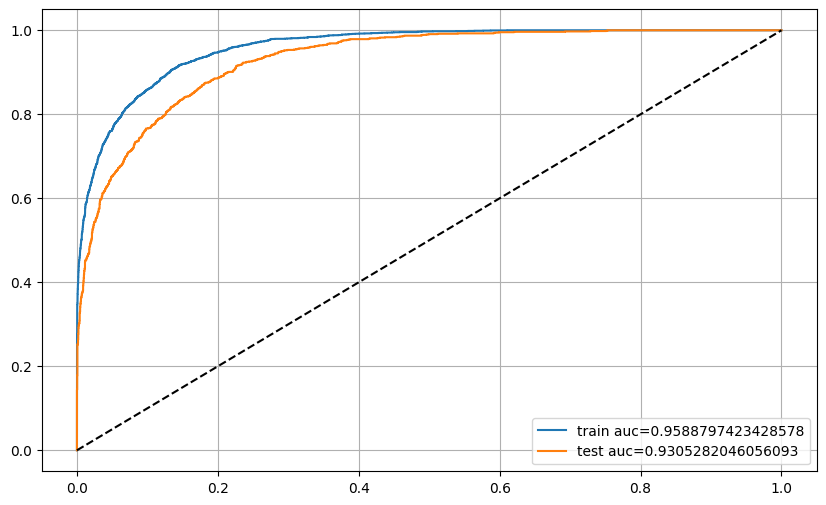

In [70]:
plt.figure(figsize=(10,6))
plt.plot(*roc_curve(y_train, train_y_pred_boosting)[:2],
         label=f'train auc={train_auc}')
plt.plot(*roc_curve(y_test, test_y_pred_boosting)[:2],
         label=f'test auc={test_auc}')

plt.plot([0,1], [0,1], '--', color='black')

plt.legend()
plt.grid()

### Задание
Примените построенную модель к данным `scoring_data`. Для этого повторите все шаги, которые вы делали с тестовыми данными:
* Заполнение пропущенных значений
* Конкатенация числовых и категориальных данных
* Создание `scoring_dataset` (здесь не нужно передавать аргумент `label`, так как мы их не знаем)
* Предсказание вероятностей 1 класса

In [71]:

scoring_cat_data=scoring_cat_data.fillna('unknown')

scoring_data_for_boosting = pd.concat([scoring_real_data,scoring_cat_data], axis='columns')

scoring_dataset=Pool(data=scoring_data_for_boosting,
                     cat_features=cat_features)
scoring_y_pred_boosting = model.predict_proba(scoring_dataset)[:, 1]#ВАШ КОД. Сохраните вероятности, предсказанные моделью

Сохраним предсказанные значения. Отправьте их на Stepik.

In [72]:
with open('scoring_y_pred_boosting.txt', "w") as f:
    f.write(', '.join([str(item) for item in scoring_y_pred_boosting]))

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from catboost import CatBoostClassifier, Pool

# data = pd.read_csv('data_train.csv').replace("?", 'unknown')
# scoring_data = pd.read_csv('data_scoring.csv').replace("?", 'unknown')

# y = data['>50K,<=50K'].map({'<=50K': 0, '>50K': 1}).astype(np.int32)
# data = data.drop(columns=['>50K,<=50K'])

# cat_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

# train_data, test_data, y_train, y_test = train_test_split(data, y, test_size=0.25)

# train_dataset = Pool(data=train_data, label=y_train, cat_features=cat_columns)
# test_dataset = Pool(data=test_data, label=y_test, cat_features=cat_columns)

# clf_params = dict(cat_features=cat_columns,
#                   loss_function='Logloss',
#                   eval_metric='AUC',
#                   early_stopping_rounds=50,
#                   random_seed=42,
#                   task_type="GPU",
#                   )

# clf = CatBoostClassifier(**clf_params)
# clf.fit(train_dataset, eval_set=test_dataset, use_best_model=True, verbose=50)

# scoring_y_pred_boosting = clf.predict_proba(scoring_data)[:, 1]

# with open('scoring_y_pred_boosting.txt', "w") as f:
#     f.write('[' + ', '.join([str(item) for item in scoring_y_pred_boosting]) + ']')